In [ ]:
import os 
import shutil
import warnings
warnings.filterwarnings('ignore')

In [ ]:
os.listdir('./drive/My Drive/machinehack leaf/')

['leaf.zip']

In [ ]:
shutil.copy('./drive/My Drive/machinehack leaf/leaf.zip','./')

'./leaf.zip'

In [ ]:
!unzip 'leaf.zip'

Archive:  leaf.zip
replace Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_df = pd.read_csv('./Train.csv')
# train_df['file_name'] = './Train/'+train_df['file_name']
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10803 entries, 0 to 10802
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_id    10803 non-null  int64 
 1   species    10803 non-null  object
 2   file_name  10803 non-null  object
dtypes: int64(1), object(2)
memory usage: 253.3+ KB


In [ ]:
train_df.head()

,file_id,species,file_name
0,55502,Abies concolor,55502.jpg
1,55510,Abies concolor,55510.jpg
2,55515,Abies concolor,55515.jpg
3,55516,Abies concolor,55516.jpg
4,55517,Abies concolor,55517.jpg


In [ ]:
from fastai.vision import *

In [ ]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=180, max_zoom=1.7, p_affine=0.9)

In [ ]:
src=(ImageList.from_df(train_df[['file_name','species']],'./Train/').split_by_rand_pct(0.2).label_from_df())

data=(src.transform(tfms,size=256).databunch().normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (8643 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Abies concolor,Abies concolor,Abies concolor,Abies concolor,Abies concolor
Path: Train;

Valid: LabelList (2160 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Ilex opaca,Acer palmatum,Cedrus atlantica,Magnolia macrophylla,Quercus nigra
Path: Train;

Test: None

In [ ]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [ ]:
learn = create_cnn(data, models.densenet121, metrics=[accuracy], pretrained=True)
learn.loss_fn = FocalLoss()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 5.75E-03


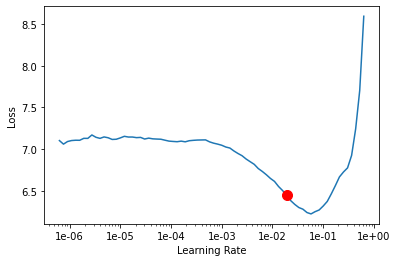

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [12]:
learn.fit_one_cycle(20,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.335398,1.679165,0.534722,05:27
1,2.080117,1.604689,0.549074,05:25
2,2.255439,2.487557,0.425000,05:24
3,2.076960,2.525656,0.416667,05:30
4,1.794896,1.924160,0.497685,05:39
5,1.685073,1.865468,0.516667,05:43
6,1.665653,1.260907,0.633796,05:41
7,1.495366,1.566997,0.574537,05:30
8,1.362802,1.515079,0.600000,05:29
9,1.237423,0.937896,0.726852,05:26


In [15]:
learn.save('leaf_densenet121_head')
learn.export('leaf_densenet121_head')

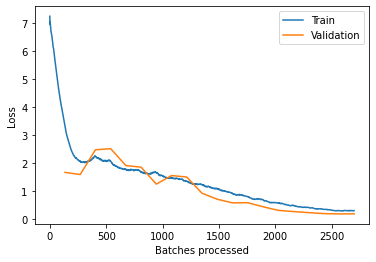

In [13]:
learn.recorder.plot_losses()

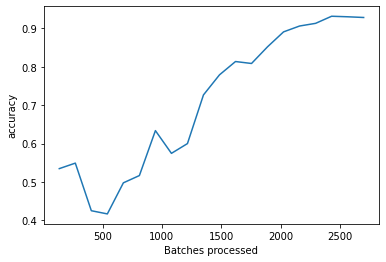

In [14]:
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 6.31E-08


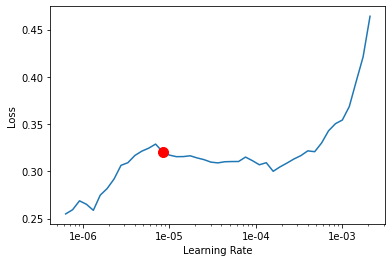

In [16]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
learn.fit_one_cycle(20,5e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.318243,0.202162,0.928241,05:42
1,0.312296,0.199924,0.929167,05:46
2,0.326051,0.199690,0.927778,05:51
3,0.312770,0.198261,0.930093,05:50
4,0.327165,0.200768,0.930556,05:50
5,0.310169,0.199152,0.928704,05:43


KeyboardInterrupt: ignored

In [19]:
learn.save('leaf_densenet121')
learn.export('leaf_densenet121')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
from sklearn import metrics
print(metrics.classification_report(interp.y_true.numpy(), interp.pred_class.numpy(),target_names =data.classes))

                              precision    recall  f1-score   support

              Abies concolor       1.00      0.90      0.95        21
          Abies nordmanniana       1.00      1.00      1.00        13
              Acer campestre       1.00      1.00      1.00         8
                Acer ginnala       1.00      1.00      1.00        16
                Acer griseum       1.00      0.89      0.94         9
                Acer negundo       0.95      1.00      0.97        18
               Acer palmatum       1.00      1.00      1.00        15
          Acer pensylvanicum       1.00      0.90      0.95        10
            Acer platanoides       1.00      1.00      1.00        17
         Acer pseudoplatanus       1.00      1.00      1.00         4
                 Acer rubrum       0.96      1.00      0.98        26
            Acer saccharinum       1.00      1.00      1.00        11
              Acer saccharum       1.00      1.00      1.00        13
              Aescu

### Inference

In [22]:
shutil.copy('./drive/My Drive/machinehack leaf/Test.zip','./')

'./Test.zip'

In [ ]:
!unzip 'Test.zip'

In [24]:
test_data = ImageList.from_folder(path='./Test/')
learn.data.add_test(test_data)

In [1]:
preds_tta = learn.TTA(ds_type=DatasetType.Test)

NameError: ignored

In [28]:
# preds = learn.predict(ds_type=DatasetType.Test)
preds = learn.get_preds(DatasetType.Test)

In [82]:
np.argmax(preds[0][0]), preds[0][0][134], preds[0][0][140]

(tensor(134), tensor(0.9465), tensor(1.3363e-09))

In [94]:
classes = learn.data.classes
preds_classes = [classes[np.argmax(i.numpy())] for i in preds[0]]

In [95]:
test_ids = [str(i).replace('Test/','').replace('.jpg','') for i in learn.data.test_ds.items]
preds_df = pd.DataFrame({'file_id':test_ids, 'species':preds_classes})
preds_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20063 entries, 0 to 20062
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file_id  20063 non-null  object
 1   species  20063 non-null  object
dtypes: object(2)
memory usage: 313.6+ KB


In [53]:
sample_submission = pd.read_csv('./drive/My Drive/machinehack leaf/sample_submission.csv')
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20063 entries, 0 to 20062
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   file_id  20063 non-null  int64 
 1   species  20063 non-null  object
dtypes: int64(1), object(1)
memory usage: 313.6+ KB


In [70]:
# preds_df['file_id'] = preds_df['file_id'].apply(int)
# submission = sample_submission.merge(preds_df, on='file_id')
# submission.info()

In [96]:
# preds_df.sort_values(['file_id'], inplace=True)
preds_df.to_csv('./fastai_densenet.csv',index=False)

In [ ]:
probs = np.array([i[0] for i in preds_tta[0].numpy().tolist()])
classes_tta = np.where(probs>0.5,0,1)

In [ ]:
test_files = [str(i).replace('/kaggle/input/machinehack-cats-and-dogs/Data Cats and Dogs/Data/Test/','') for i in learn.data.test_ds.items]
preds_tta_df = pd.DataFrame({'File_Name':test_files, 'Category':classes_tta})
preds_tta_df.info()
